# Simulating Gaia distances 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

The Bailer-Jones prior.

In [42]:
def bj_prior(r, L):
    return 1./(2*L**3) * r**2 * np.exp(-r/L)

Text(0.5, 0, 'Distance [pc]')

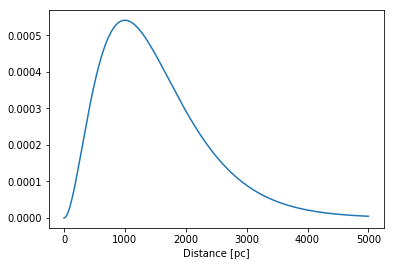

In [43]:
L = 500  # The modal value of L in Bailer-Jones (2018)
r = np.linspace(0, 5000, 1000)
prior = bj_prior(r, L)

plt.plot(r, prior)
plt.xlabel("Distance [pc]")

Draw samples from the prior using Importance Sampling.

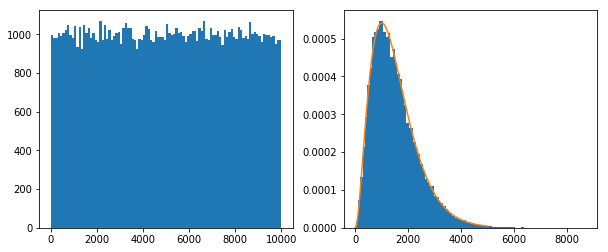

In [57]:
nstars = 100000
np.random.seed(42)

def importance_sample(nstars, lower_lim, upper_lim):

    # Draw samples from a uniform distribution
    samples = np.random.uniform(lower_lim, upper_lim, nstars)

    # Calculate the probability of each sample.
    weights = 1./nstars

    # Evaluate the target distribution
    eval_pdf = bj_prior(samples, L)

    # Calculate the new weights and normalize
    w = eval_pdf/weights
    w /= float(sum(w))

    # Resample with replacement and weights.
    _samples = np.random.choice(samples, nstars, replace=True, p=w)
    
    return samples, _samples

samples, _samples = importance_sample(nstars, 0, 10000)
    
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax.hist(samples, 100);

ax1 = fig.add_subplot(122)
ax1.hist(_samples, 100, density=True);
ax1.plot(r, prior, color="C1")

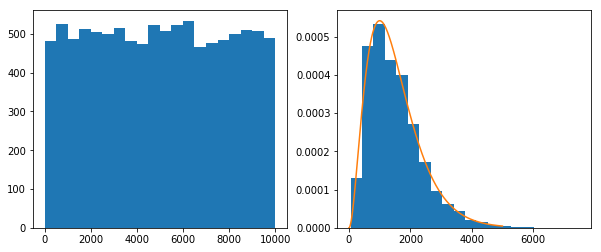

In [61]:
nstars = 10000
samples, _samples = importance_sample(nstars, 0, 10000)
    
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax.hist(samples, 20);
ax1 = fig.add_subplot(122)
ax1.hist(_samples, 20, density=True);
ax1.plot(r, prior, color="C1")

Transform the noise-free distances to parallax, apply noise, then transform back.

In [113]:
np.random.seed(1)

r = _samples*1
r_kpc = r*1e-3

parallax_as = 1./r

Find a formula for parallax uncertainty.

0.026627795803048797 0.00022581031140021506
relative parallax uncertainty = 0.02663D + 0.00023 (Distance in kpc)


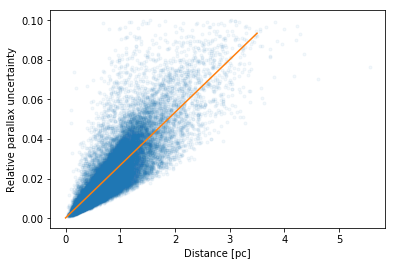

In [114]:
df = pd.read_csv("gaia_mc.csv")

plt.plot(1./df.parallax, df.parallax_error/df.parallax, ".", alpha=.05)
plt.xlabel("Distance [pc]")
plt.ylabel("Relative parallax uncertainty")

x, y = 1./df.parallax, df.parallax_error/df.parallax
AT = np.vstack((np.ones_like(x), x))
ATA = np.dot(AT, AT.T)
b, m = np.linalg.solve(ATA, np.dot(AT, y))

xs = np.linspace(0, 3.5)
plt.plot(xs, m*xs + b)
print(m, b)

print("relative parallax uncertainty = {0:.5f}D + {1:.5f} (Distance in kpc)".format(m, b))

In [171]:
relative_parallax_error = np.abs(m*r_kpc + b + np.random.randn(nstars)*.01*r_kpc)
parallax_error_as = relative_parallax_error * parallax_as
parallax_as_noise = parallax_as + np.random.randn(nstars)*parallax_error_as

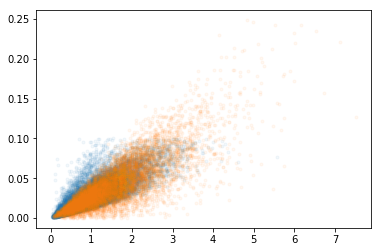

In [172]:
plt.plot(1./df.parallax, df.parallax_error/df.parallax, ".", alpha=.05)
plt.plot(r_kpc, relative_parallax_error, ".", alpha=.05)

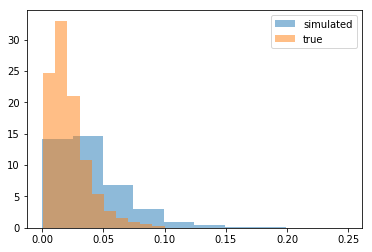

In [173]:
plt.hist(relative_parallax_error, density=True, alpha=.5, label="simulated");
plt.hist(df.parallax_error/df.parallax, density=True, alpha=.5, label="true");
plt.legend()

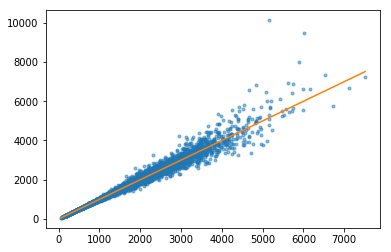

In [174]:
plt.plot(r, (1./parallax_as_noise), ".", alpha=.5)
x = np.linspace(min(r), max(r), 100)
plt.plot(x, x)

In [175]:
parallax_df = pd.DataFrame(dict({"parallax_mas": parallax_as_noise*1e3, 
                                 "parallax_error": parallax_error_as*1e3,
                                 "true_distance_kpc": r_kpc}))
parallax_df.to_csv("parallaxes.csv")

In [170]:
print(sum(parallax_as_noise < 0))

0
